In [1]:
import pandas as pd
from utils.text import SparseTextProcessor
import seaborn as sns

# Carregando dados de análise

In [2]:
data_df = pd.read_csv("/home/kenzosaki/mestrado/data/tweetsentbr/tweetsentbr_test.csv", index_col=0)

In [3]:
id2label = {
    0: "neutro",
    1: "positivo",
    2: "negativo"
}

In [4]:
# Convertendo ids para labels para facilitar interpretação
data_df["label"] = data_df["label"].map(id2label)

In [5]:
data_df.head()

,label,text
2403,positivo,Começou o The Noite com o Charlie Hunnam
1349,negativo,"No twitter a 3ª feira é chata,pois todo mundo ..."
5422,neutro,Bial declamando os do garçom Conversa Com Bial
1262,neutro,AI MEU DEUS É AGORA Master Chef BR
5438,negativo,A Miriam só não roda pq eu acho que o tal sorv...


# Definindo procedimento de pre-processamento de texto

Pipeline simples de pre-processamento de texto, incluindo: conversão para lower-case, remoção de stop-words e stemmização.

In [6]:
import spacy
nlp = spacy.load("pt_core_news_sm")

In [7]:
from typing import Iterable

def apply_preprocessing_pipeline(text: str) -> Iterable[str]:

    tokens = nlp(text)
    final_tokens = []

    for token in tokens:

        lemma = token.lemma_

        if token.is_stop: continue              # remoção de stop-words
        if token.is_punct: continue             # remoção de pontuação
        if len(lemma.strip()) == 0: continue    # ignorar tokens "vazios"

        final_tokens.append(lemma)
    
    return final_tokens

# Conversão dos textos para representações esparsas

In [8]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

In [24]:
params = {
    "max_features": 10000,                      # tamanho máximo de vocabulário
    "ngram_range": (1, 3),                      # ngrams 
    "tokenizer": apply_preprocessing_pipeline   # pipeline de pre processamento pelo spacy
}

In [25]:
vectorizer = CountVectorizer(**params)
# vectorizer = TfidfVectorizer(**params)

In [26]:
text_vectors = vectorizer.fit_transform(data_df["text"].values)

In [27]:
text_vectors.shape

(2463, 10000)

In [28]:
vectorizer.get_feature_names()[:10]

["'s",
 '+',
 '1',
 '1 globo',
 '1 globo esporte',
 '=',
 '@_jucampelo',
 '@adrianecarpi',
 '@adrianecarpi @_jucampelo',
 '@anamariabraga']

# Agrupamento usando K-means

In [29]:
from sklearn.cluster import KMeans

In [30]:
kmeans = KMeans(n_clusters=2, n_init=100, init='random', max_iter=500)

kmeans.fit(text_vectors)

KMeans(init='random', max_iter=500, n_clusters=2, n_init=100)

In [31]:
data_df["cluster"] = kmeans.labels_

# Avaliando silhueta do agrupamento gerado

In [32]:
from sklearn.metrics import silhouette_samples
from yellowbrick.cluster.silhouette import silhouette_visualizer

In [33]:
data_df["silhouette"] = silhouette_samples(text_vectors, kmeans.labels_)

In [34]:
mean_silh = data_df["silhouette"].mean()

In [35]:
print(f"- EE: {kmeans.inertia_}")
print(f"- Mean silhouette: {mean_silh}")

- EE: 2354.513499402486
- Mean silhouette: 0.017558015456826684


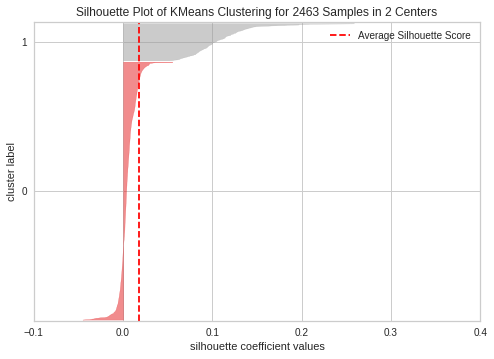

/home/kenzosaki/anaconda3/envs/transformers/lib/python3.7/site-packages/sklearn/base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


SilhouetteVisualizer(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7f8873fe2ed0>,
                     model=None)

In [36]:
silhouette_visualizer(
    kmeans,
    X=text_vectors.todense(),
    y=data_df["label"].values,
    is_fitted=True
)

# Distribuição de classes por cluster

In [37]:
import matplotlib.pyplot as plt

Text(0.5, 0, 'Cluster 1')

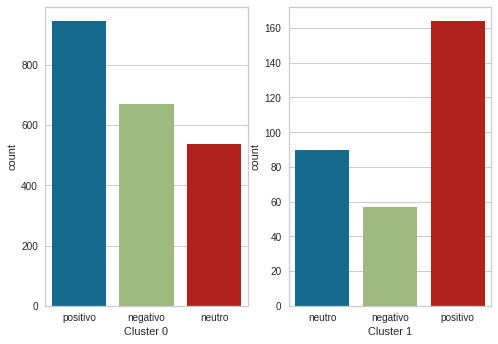

In [38]:
fig, axes = plt.subplots(1,2)

c0_df = data_df[data_df["cluster"] == 0]
c1_df = data_df[data_df["cluster"] == 1]

sns.countplot(data=c0_df, x="label", ax=axes[0])
axes[0].set_xlabel("Cluster 0")
sns.countplot(data=c1_df, x="label", ax=axes[1])
axes[1].set_xlabel("Cluster 1")